# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [1]:
from Functions import get_result, plot_precision_recall_vs_threshold, plot_roc_curve
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC, Metric
from keras.optimizers import Adam
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2025-01-21 21:15:14.845290: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 21:15:15.158030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 21:15:15.158066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 21:15:15.209082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 21:15:15.308794: I tensorflow/core/platform/cpu_feature_guar

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

Since Tensorflow do not have a built-in metric for F1 score, we'll create one. Thus can we monitor the f1 score through the training.

In [3]:
class CustomF1Score(Metric):
   def __init__(self, name='custom_f1', **kwargs):
      super().__init__(name=name, **kwargs)
      # Initialize metric state variables
      self.true_positives = self.add_weight(name='tp', initializer='zeros')
      self.false_positives = self.add_weight(name='fp', initializer='zeros')
      self.false_negatives = self.add_weight(name='fn', initializer='zeros')

   def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = K.cast(y_pred > 0.5, 'float32')  # Convert probabilities to binary predictions
      y_true = K.cast(y_true, 'float32')        # Ensure labels are float32
   
      # Calculate and accumulate metrics:
      self.true_positives.assign_add(K.sum(y_true * y_pred)) 
      self.false_positives.assign_add(K.sum((1 - y_true) * y_pred)) 
      self.false_negatives.assign_add(K.sum(y_true * (1 - y_pred))) 

   def result(self):
      precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
      recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
      return 2 * precision * recall / (precision + recall + K.epsilon())

   def reset_state(self):
      # Reset all accumulators to zero at the start of each epoch
      self.true_positives.assign(0)
      self.false_positives.assign(0)
      self.false_negatives.assign(0)

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [4]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'Recall', 
        'Precision', 
        'F1'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
BATCH_SIZE = 2048

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [6]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(),
                    loss=BinaryCrossentropy(from_logits=False),
                    metrics=[
                        BinaryAccuracy(name='Accuracy'),
                        Precision(name='Precision'), 
                        Recall(name='Recall'), 
                        CustomF1Score(name='F1')
                    ])

    return model

### Without handling imbalance

In [7]:
model = get_simple_model()

2025-01-21 21:15:17.630337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 21:15:17.814838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 21:15:17.814895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 21:15:17.818997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 21:15:17.819056: I external/local_xla/xla/stream_executor

In [8]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20


2025-01-21 21:15:19.489103: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-21 21:15:19.947475: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa4500d62e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-21 21:15:19.947509: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-01-21 21:15:19.959992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-21 21:15:19.988824: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1737490520.062333   26701 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - 3s 9ms/step - loss: 0.0291 - Accuracy: 0.9985 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0109 - val_Accuracy: 0.9986 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 2/20
134/134 [==============================] - 1s 7ms/step - loss: 0.0107 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0106 - val_Accuracy: 0.9986 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 3/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0104 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0104 - val_Accuracy: 0.9986 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 4/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0103 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0

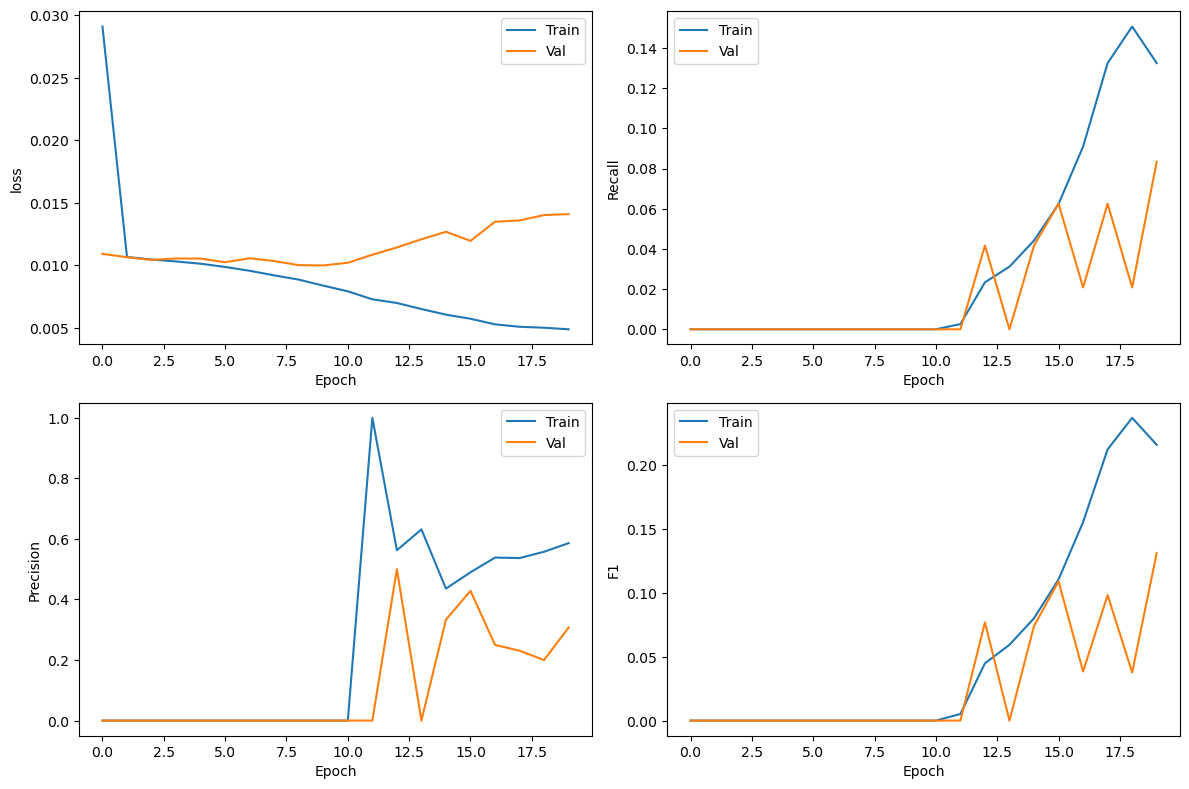

In [9]:
plot_training_metrics(history_unhandled)

In [10]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


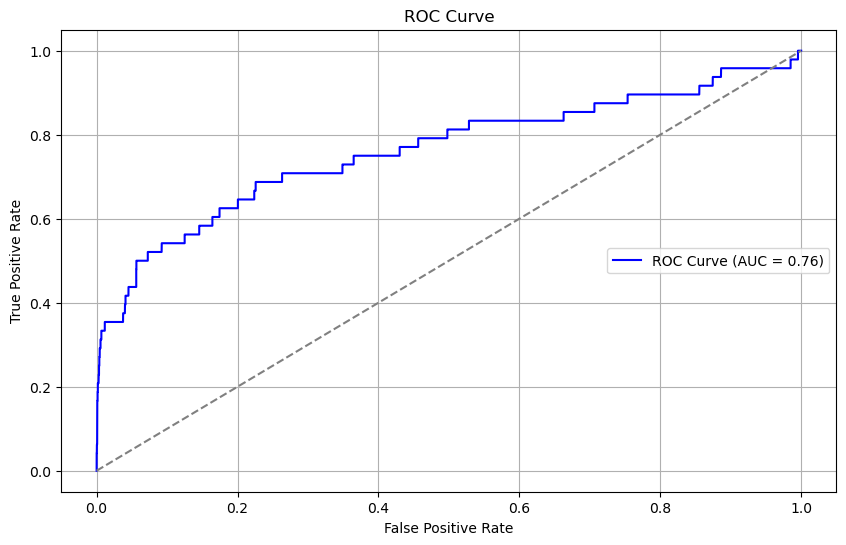

0.7622535171651355

In [11]:
plot_roc_curve(Y_test, test_predictions)

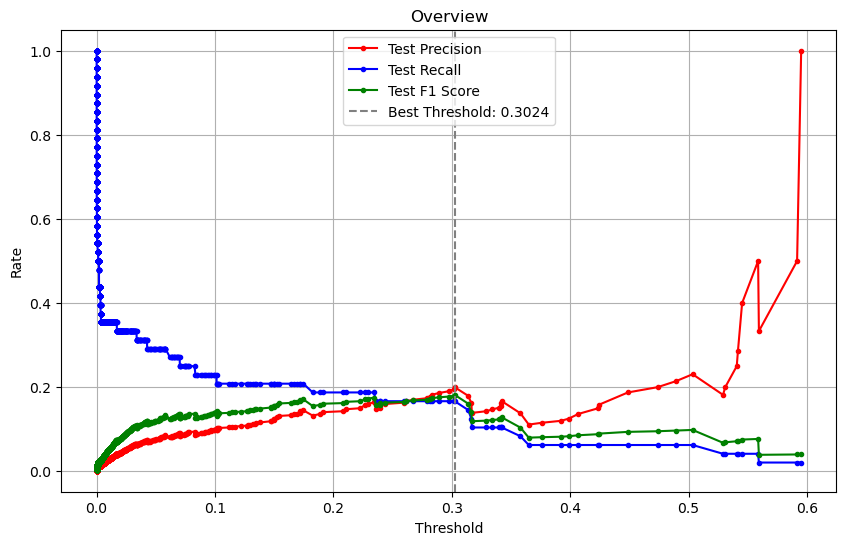

In [12]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

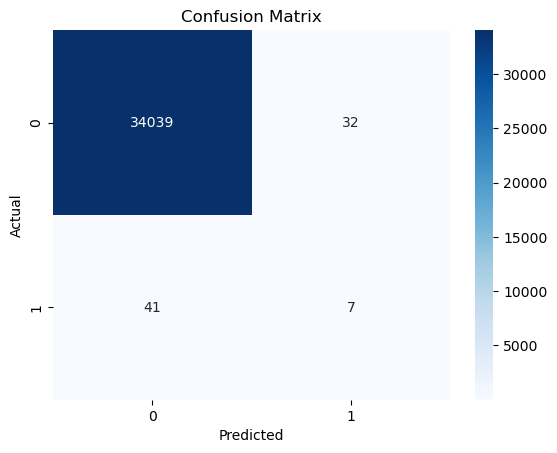

Recall       = 0.15
Precision    = 0.18
F1           = 0.16


In [13]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using class weights

In [14]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007062691013688, 1: 354.4727272727273}

In [15]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 3s 10ms/step - loss: 0.6921 - Accuracy: 0.6277 - Precision: 0.0017 - Recall: 0.4390 - F1: 0.0033 - val_loss: 0.7240 - val_Accuracy: 0.3732 - val_Precision: 0.0017 - val_Recall: 0.7500 - val_F1: 0.0034
Epoch 2/20
134/134 [==============================] - 1s 8ms/step - loss: 0.6800 - Accuracy: 0.5593 - Precision: 0.0017 - Recall: 0.5299 - F1: 0.0034 - val_loss: 0.7112 - val_Accuracy: 0.6146 - val_Precision: 0.0019 - val_Recall: 0.5208 - val_F1: 0.0038
Epoch 3/20
134/134 [==============================] - 1s 8ms/step - loss: 0.6536 - Accuracy: 0.6414 - Precision: 0.0023 - Recall: 0.5844 - F1: 0.0046 - val_loss: 0.6234 - val_Accuracy: 0.8044 - val_Precision: 0.0033 - val_Recall: 0.4583 - val_F1: 0.0066
Epoch 4/20
134/134 [==============================] - 1s 8ms/step - loss: 0.6188 - Accuracy: 0.7376 - Precision: 0.0031 - Recall: 0.5688 - F1: 0.0061 - val_loss: 0.6948 - val_Accuracy: 0.5757 - val_Precision: 0.0022 - val_Recall: 0.6667 

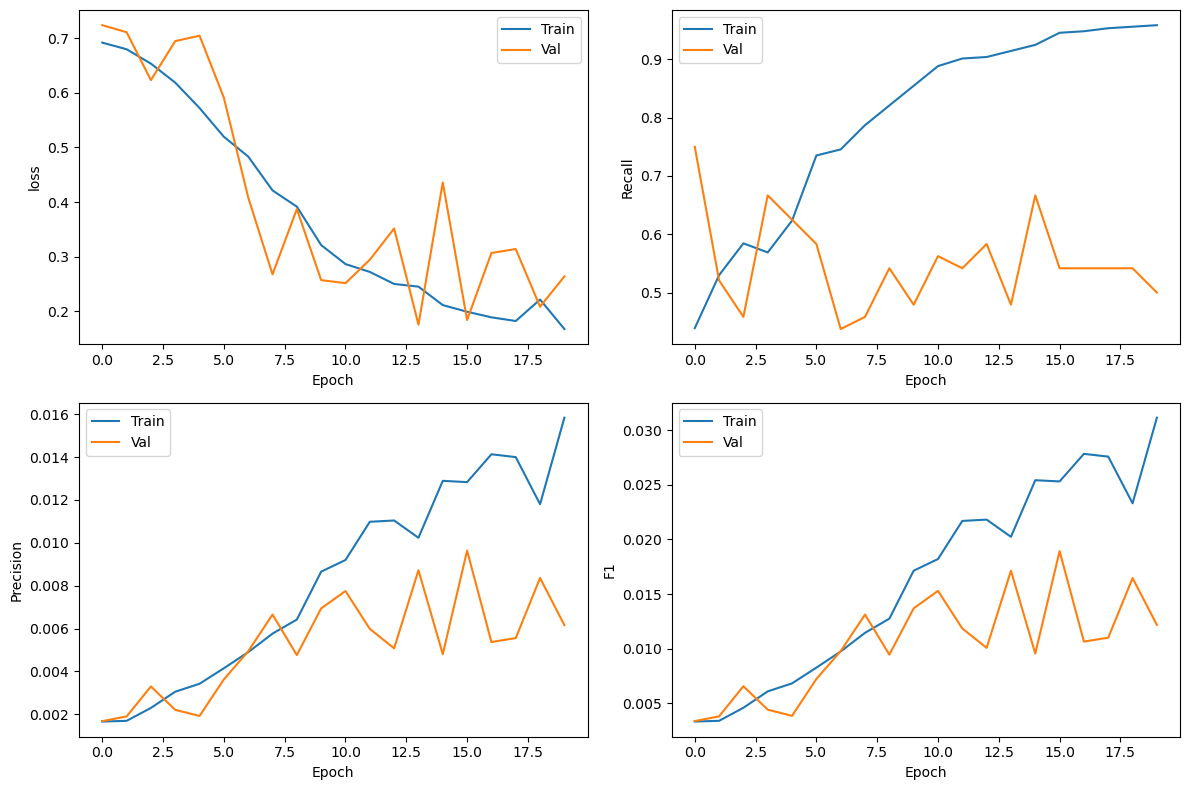

In [16]:
plot_training_metrics(history_class_weights)

In [17]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


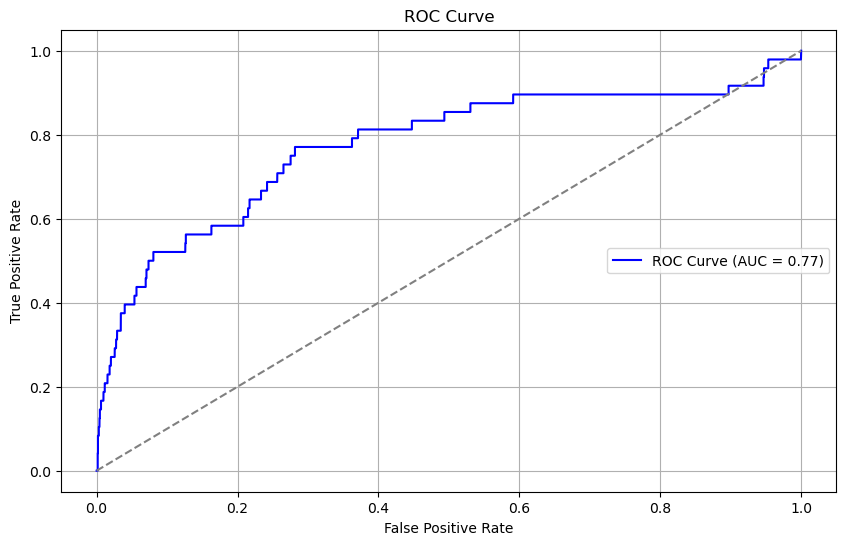

0.7740719746998914

In [18]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


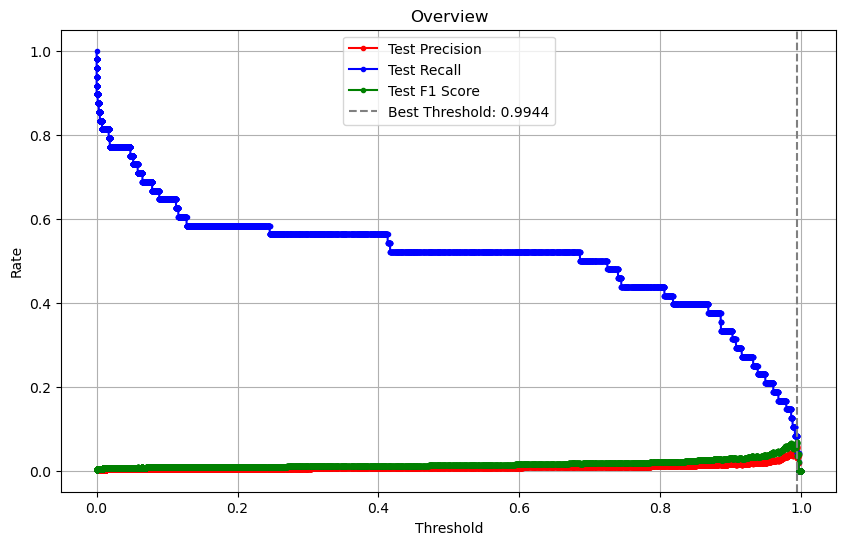

In [19]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

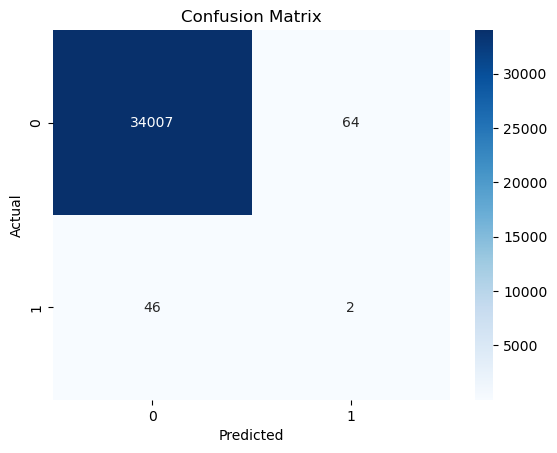

Recall       = 0.04
Precision    = 0.03
F1           = 0.04


In [20]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using oversampling 

There are different kinds of techniques for oversampling. The simplest would be Random oversampling, which just duplicates existing samples from the minority class to balance the distribution. However, this can result in overfitting as the same samples are repeated. Instead we could use Synthetic Minority Over-sampling Technique (SMOTE). The way SMOTE does it, is by generating synthetic examples in the feature space of the minority class, which helps to overcome the overfitting problem, since it is not just a copy of existing samples. The drawback of SMOTE is it can generate noisy or unrealistic samples. We will however use SMOTE to oversample on the risky customers.

In [21]:
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

In [22]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 3s 8ms/step - loss: 0.1802 - Accuracy: 0.9228 - Precision: 0.9103 - Recall: 0.9380 - F1: 0.9239 - val_loss: 0.0550 - val_Accuracy: 0.9822 - val_Precision: 0.0287 - val_Recall: 0.3542 - val_F1: 0.0530
Epoch 2/20
267/267 [==============================] - 2s 7ms/step - loss: 0.0318 - Accuracy: 0.9906 - Precision: 0.9860 - Recall: 0.9955 - F1: 0.9907 - val_loss: 0.0519 - val_Accuracy: 0.9866 - val_Precision: 0.0383 - val_Recall: 0.3542 - val_F1: 0.0691
Epoch 3/20
267/267 [==============================] - 2s 7ms/step - loss: 0.0258 - Accuracy: 0.9926 - Precision: 0.9893 - Recall: 0.9960 - F1: 0.9926 - val_loss: 0.0852 - val_Accuracy: 0.9762 - val_Precision: 0.0237 - val_Recall: 0.3958 - val_F1: 0.0447
Epoch 4/20
267/267 [==============================] - 2s 8ms/step - loss: 0.0224 - Accuracy: 0.9937 - Precision: 0.9908 - Recall: 0.9968 - F1: 0.9938 - val_loss: 0.0492 - val_Accuracy: 0.9874 - val_Precision: 0.0451 - val_Recall: 0.3958 -

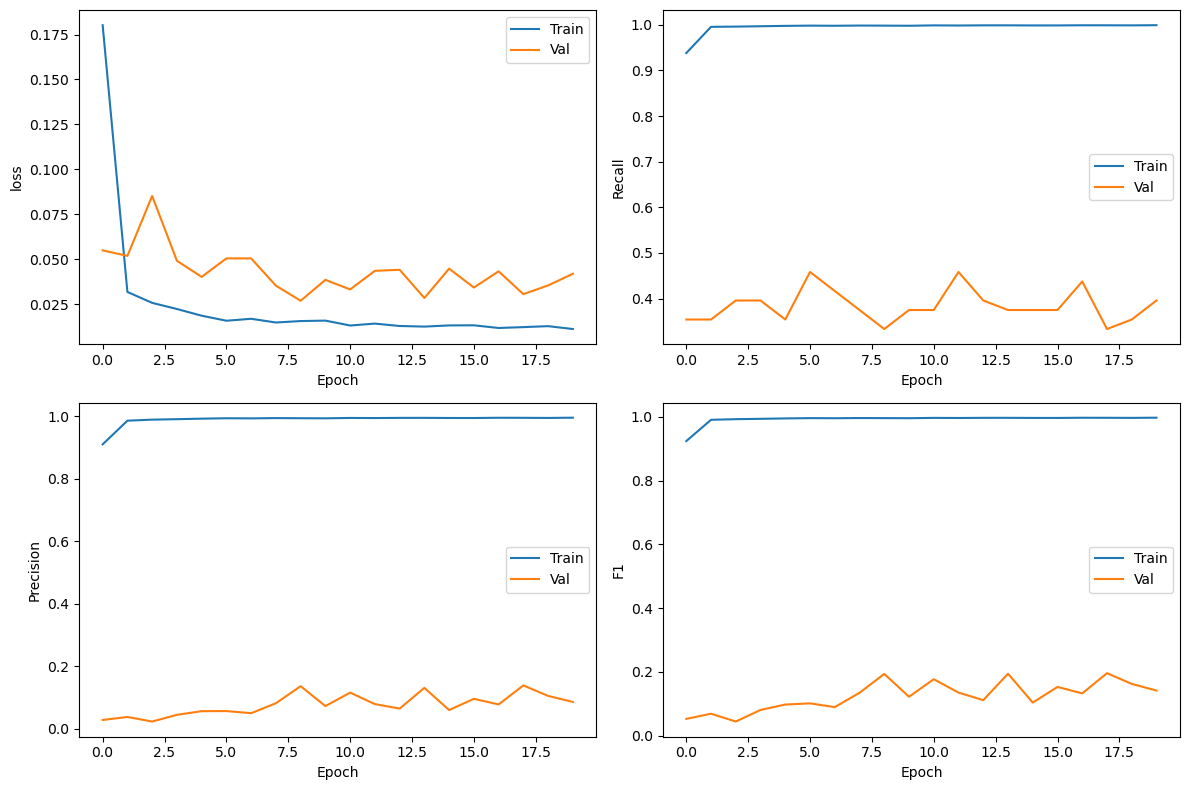

In [23]:
plot_training_metrics(history_oversampled)

In [24]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


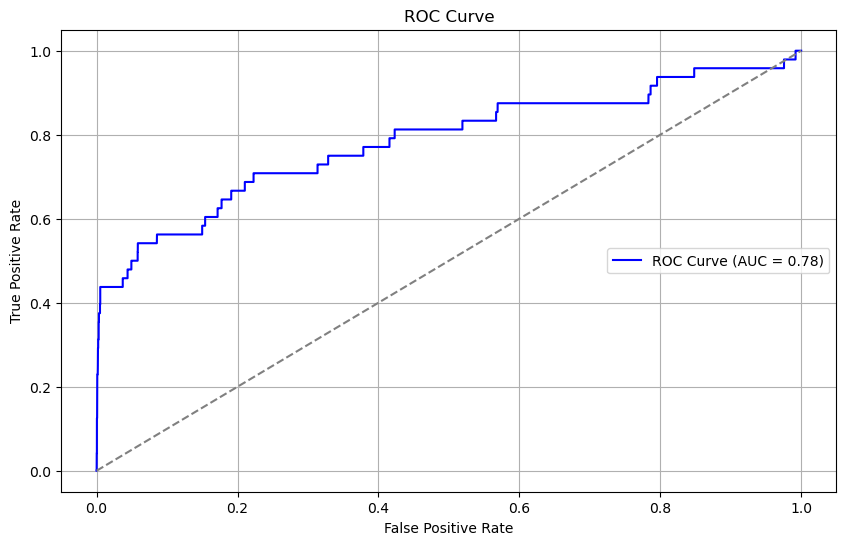

0.7845485652509955

In [25]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


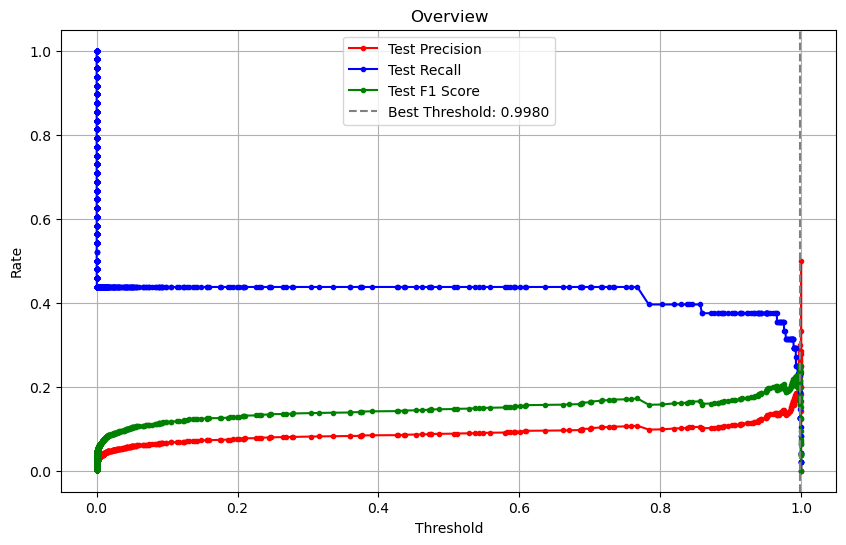

In [26]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

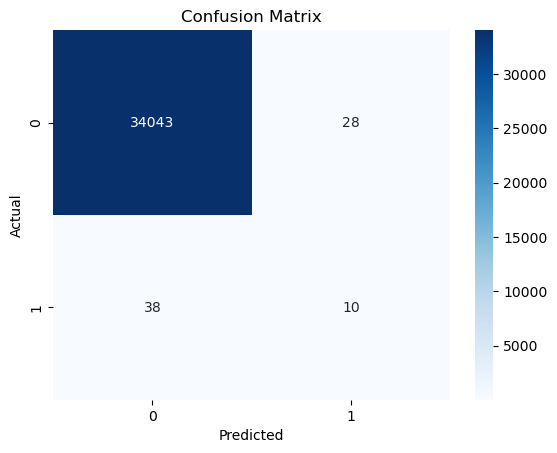

Recall       = 0.21
Precision    = 0.26
F1           = 0.23


In [27]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
Lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [28]:
def model_builder(hp):
    """
    Build and compile a model using hyperparameters defined in Keras Tuner.

    Args:
        hp (kt.HyperParameters): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """

    model = Sequential()
    model.add(Dense(
        units=hp.Int("input_layer", min_value=128, max_value=1024, step=32), 
        input_shape=(X_train_oversampled.shape[1],),
        activation='relu',
        kernel_regularizer=l2(hp.Float(f"l2_0", min_value=0.0001, max_value=0.1, step=0.0005))
    ))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(
            # Tune the number of units
            units=hp.Int(f"units_{i+1}", min_value=128, max_value=2048, step=128),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f"l2_{i}", min_value=0.0001, max_value=0.1, step=0.0005))
        ))

        # Optionally add Dropout and BatchNormalization
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.7, step=0.1)))
        if hp.Boolean(f"batch_norm_{i}"):
            model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])), # Tune the leraning rate
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='Accuracy'),
            Precision(name='Precision'), 
            Recall(name='Recall'), 
            CustomF1Score(name='F1')
        ])
    
    return model

In [29]:
monitor = 'val_F1'

In [30]:
model_builder(kt.HyperParameters())

tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective=kt.Objective(monitor, direction="max"),   # Objective to optimize
    max_trials=30,                                      # Number of trials to run during the search
    executions_per_trial=2,                             # Models that should be built and fit for each trial
    overwrite=True,                                     # Overwrite the previous results
    directory="Saved models",
    project_name="NN_Model_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
l2_0 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': 0.0005, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 2048, 'step': 128, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [31]:
# Early stopping callback for efficient training
early_stopping = EarlyStopping(
    monitor=monitor,
    patience=7,
    mode='max',
    restore_best_weights=True
)

In [32]:
tuner.search(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 02m 34s]
val_F1: 0.15272165089845657

Best val_F1 So Far: 0.17051098495721817
Total elapsed time: 00h 43m 24s


bedste før: Best val_F1 So Far: 0.21515952050685883

In [33]:
# See the result of all the models
tuner.results_summary()

Results summary
Results in Saved models/NN_Model_tuner
Showing 10 best trials
Objective(name="val_F1", direction="max")

Trial 19 summary
Hyperparameters:
input_layer: 1024
l2_0: 0.0091
num_layers: 5
units_1: 512
dropout_0: True
batch_norm_0: False
learning_rate: 0.0001
dropout_rate_0: 0.2
units_2: 1408
l2_1: 0.0826
dropout_1: True
batch_norm_1: True
dropout_rate_1: 0.2
units_3: 1152
l2_2: 0.0391
dropout_2: False
batch_norm_2: True
units_4: 2048
l2_3: 0.0801
dropout_3: True
batch_norm_3: False
units_5: 1024
l2_4: 0.042100000000000005
dropout_4: False
batch_norm_4: False
dropout_rate_2: 0.2
dropout_rate_3: 0.30000000000000004
dropout_rate_4: 0.6
Score: 0.17051098495721817

Trial 24 summary
Hyperparameters:
input_layer: 512
l2_0: 0.0136
num_layers: 3
units_1: 128
dropout_0: True
batch_norm_0: True
learning_rate: 0.001
dropout_rate_0: 0.5
units_2: 1792
l2_1: 0.0806
dropout_1: False
batch_norm_1: False
dropout_rate_1: 0.2
units_3: 640
l2_2: 0.0726
dropout_2: False
batch_norm_2: False
units

In [34]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for value in best_hps.values:
    print(value, ':', best_hps.values[value])  # Inspect the hyperparameter values

input_layer : 1024
l2_0 : 0.0091
num_layers : 5
units_1 : 512
dropout_0 : True
batch_norm_0 : False
learning_rate : 0.0001
dropout_rate_0 : 0.2
units_2 : 1408
l2_1 : 0.0826
dropout_1 : True
batch_norm_1 : True
dropout_rate_1 : 0.2
units_3 : 1152
l2_2 : 0.0391
dropout_2 : False
batch_norm_2 : True
units_4 : 2048
l2_3 : 0.0801
dropout_3 : True
batch_norm_3 : False
units_5 : 1024
l2_4 : 0.042100000000000005
dropout_4 : False
batch_norm_4 : False
dropout_rate_2 : 0.2
dropout_rate_3 : 0.30000000000000004
dropout_rate_4 : 0.6


In [35]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

In [36]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              55296     
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1408)              722304    
                                                                 
 dropout_3 (Dropout)         (None, 1408)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 1408)              5632      
 chNormalization)                                                
                                                      

Before training the best model again we are going to utilize some additional callbacks:
- ModelCheckpoint: To save the best weights depending on a monitored metric.
- TensorBoard: 

In [37]:
# Model checkpoint callback for securing best weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=r'Saved models/NN_best_model.keras',
    save_weights_only=False, # Save the entire model (architecture + weights)
    monitor=monitor,
    mode='max',
    save_best_only=True
)

In [38]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [39]:
# Train the best model and capture the training history
history_best = best_model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    validation_data=(X_val, Y_val),
    epochs=50, 
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/50
267/267 [==============================] - 7s 19ms/step - loss: 138.2888 - Accuracy: 0.8587 - Precision: 0.8459 - Recall: 0.8772 - F1: 0.8612 - val_loss: 47.6656 - val_Accuracy: 0.0015 - val_Precision: 0.0014 - val_Recall: 1.0000 - val_F1: 0.0028
Epoch 2/50
267/267 [==============================] - 4s 17ms/step - loss: 20.1073 - Accuracy: 0.9854 - Precision: 0.9770 - Recall: 0.9943 - F1: 0.9855 - val_loss: 6.0680 - val_Accuracy: 0.9981 - val_Precision: 0.0952 - val_Recall: 0.0417 - val_F1: 0.0580
Epoch 3/50
267/267 [==============================] - 4s 16ms/step - loss: 2.6885 - Accuracy: 0.9890 - Precision: 0.9824 - Recall: 0.9957 - F1: 0.9890 - val_loss: 1.0989 - val_Accuracy: 0.9768 - val_Precision: 0.0280 - val_Recall: 0.4583 - val_F1: 0.0528
Epoch 4/50
267/267 [==============================] - 4s 16ms/step - loss: 0.7060 - Accuracy: 0.9907 - Precision: 0.9847 - Recall: 0.9969 - F1: 0.9907 - val_loss: 0.5420 - val_Accuracy: 0.9764 - val_Precision: 0.0275 - val_Recall: 

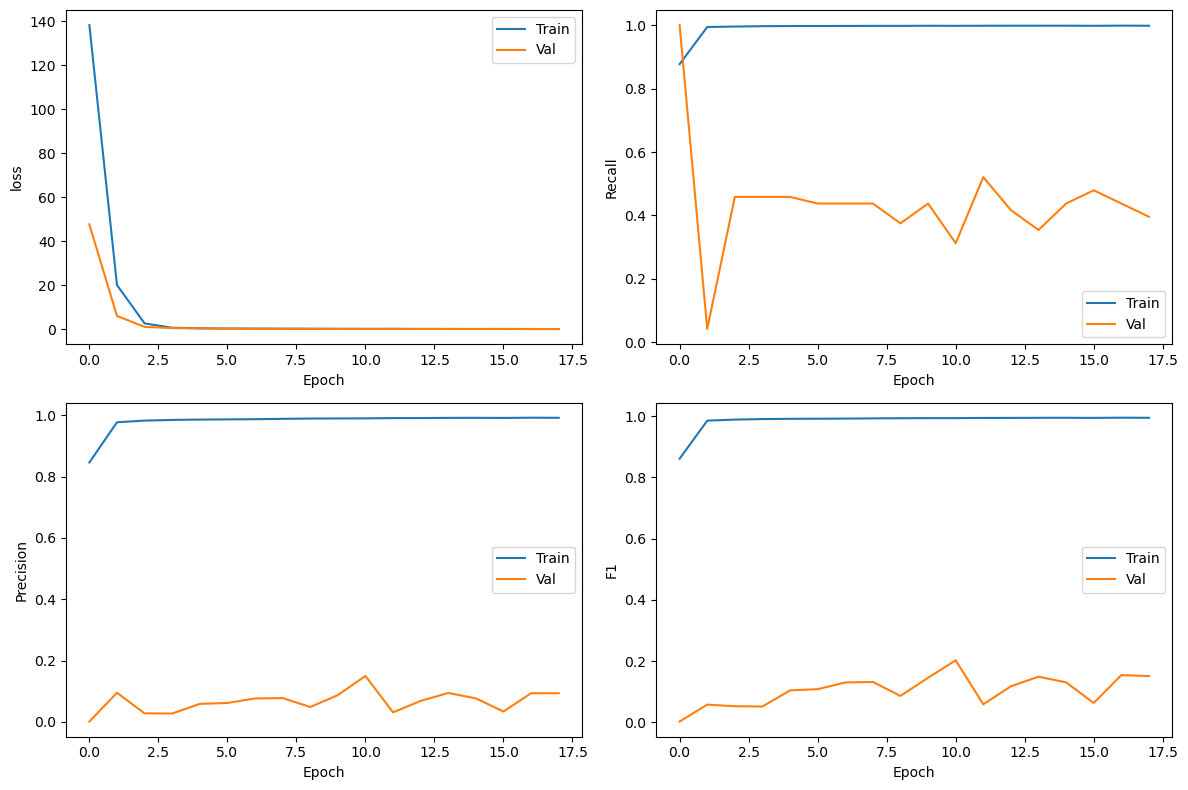

In [40]:
plot_training_metrics(history_best)

In [41]:
# Test model on test set
test_predictions = best_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


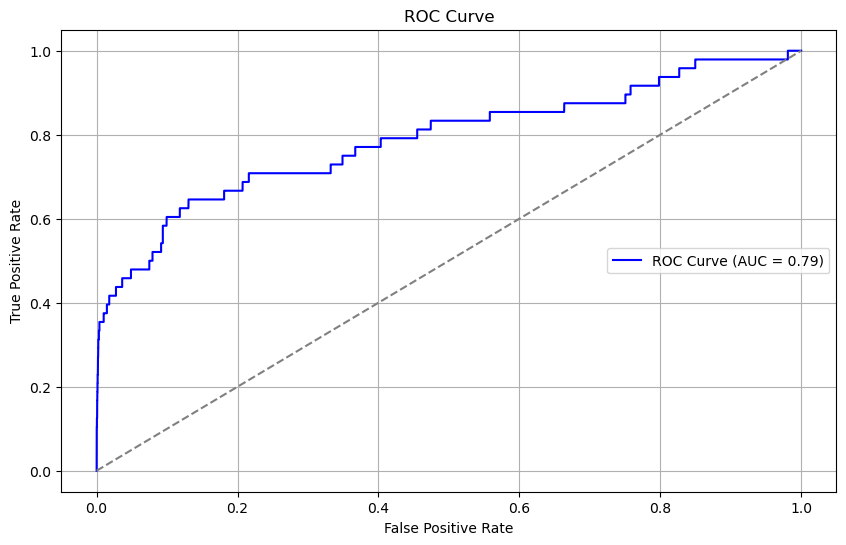

0.789000665277411

In [42]:
plot_roc_curve(Y_test, test_predictions)

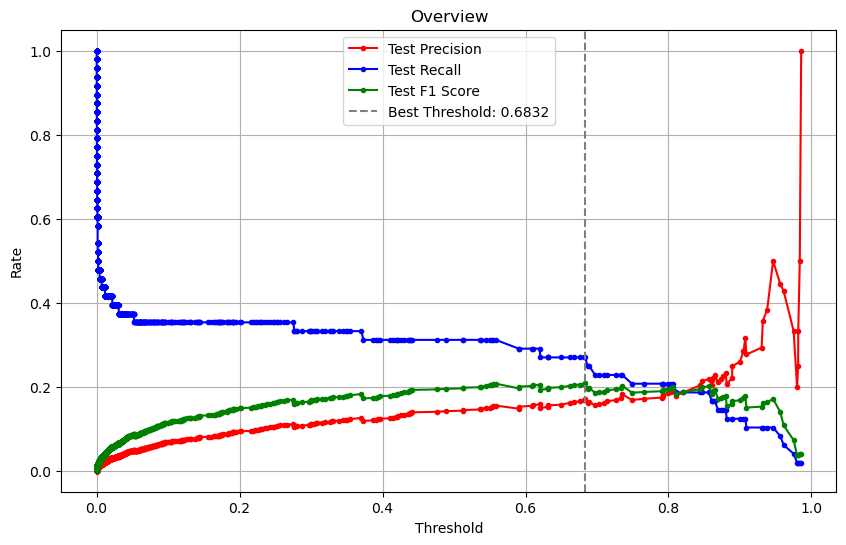

In [43]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

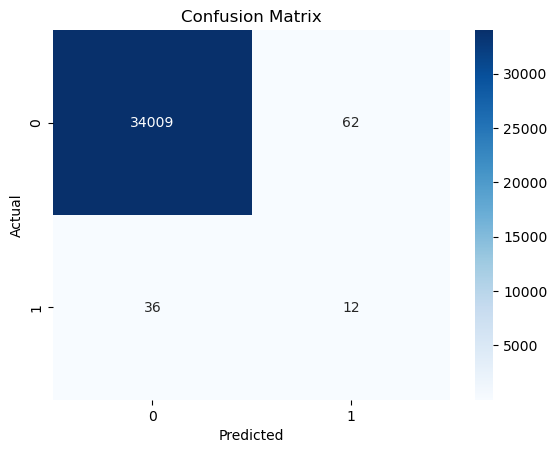

Recall       = 0.25
Precision    = 0.16
F1           = 0.2


In [44]:
_ = get_result(Y_test, test_predictions, best_threshold)